In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


=====================Data preparation=============================

In [6]:
# -----------------
# Helper: stratified sampling
# -----------------
def stratified_sample(df, target_col, frac=None, n=None, random_state=42):
    """Return stratified sample keeping target ratio"""
    if frac is not None:
        df_sampled = df.groupby(target_col, group_keys=False)\
                       .apply(lambda x: x.sample(frac=frac, random_state=random_state))
    elif n is not None:
        class_counts = df[target_col].value_counts()
        total = class_counts.sum()
        df_sampled = []
        for c, count in class_counts.items():
            take = int(n * (count / total))
            df_sampled.append(df[df[target_col] == c].sample(n=take, random_state=random_state))
        df_sampled = pd.concat(df_sampled)
    else:
        df_sampled = df
    return df_sampled.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

In [7]:
dataset = "B"

if dataset == "A":
  dataset_name = "/content/drive/MyDrive/wustl_iiot_2021.csv"
  target = 'Target'
  drop_cols = ["StartTime", "LastTime", "Traffic", "SrcAddr", "DstAddr"]
  frac=0.1
elif dataset == "B":
  dataset_name = "/content/drive/MyDrive/creditcard.csv"
  target = 'Class'
  drop_cols = ["Time"]
  frac=0.5

In [8]:
df = pd.read_csv(dataset_name)

df = df.drop(columns=[c for c in drop_cols if c in df.columns])


print(f"Original dataset shape: {df.shape}, anomaly ratio={df[target].mean():.4%}")

# Stratified sampling
df_sampled = stratified_sample(df, target, frac=frac, random_state=0)
print(f"Sampled dataset shape: {df_sampled.shape}, anomaly ratio={df_sampled[target].mean():.4%}")

df_sampled = df_sampled.reset_index(drop=True)

features = df_sampled.columns

train_df, test_df = train_test_split(
    df_sampled, test_size=0.2, stratify=df_sampled[target], random_state=0
)

train_df, valid_df = train_test_split(
    train_df, test_size= 0.2 / 0.6, stratify=train_df[target], random_state=0
)

print(f"Train shape: {train_df.shape}, anomaly ratio={train_df[target].mean():.4%}")
print(f"Valid shape: {valid_df.shape}, anomaly ratio={valid_df[target].mean():.4%}")
print(f"Test shape:  {test_df.shape},  anomaly ratio={test_df[target].mean():.4%}")

# Add the "Set" column
train_df["Set"] = "train"
valid_df["Set"] = "valid"
test_df["Set"] = "test"

# Combine them back together
train = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index


categorical_columns = []
categorical_dims = {}

nunique = train.nunique()
types = train.dtypes

for col in train.columns:
    if types[col] == 'object':
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

unused_feat = ["Set"]

features = [col for col in df_sampled.columns if col not in unused_feat + [target]]

print(features)

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

print(categorical_columns)
print(cat_dims)

Original dataset shape: (284807, 30), anomaly ratio=0.1727%
Sampled dataset shape: (142404, 30), anomaly ratio=0.1727%


/tmp/ipython-input-2184620091.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=random_state))


Train shape: (75948, 30), anomaly ratio=0.1725%
Valid shape: (37975, 30), anomaly ratio=0.1738%
Test shape:  (28481, 30),  anomaly ratio=0.1720%
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
['Set']
[]


In [9]:
target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

======================================================================

==================================Model================================

In [12]:
import torch
import torch.nn.functional as F
from torch import nn, einsum

from einops import rearrange

In [13]:
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

# classes

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# attention

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x, **kwargs):
        return self.net(x)

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 16,
        dropout = 0.
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = sim.softmax(dim = -1)
        dropped_attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', dropped_attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out), attn

# transformer

class Transformer(nn.Module):
    def __init__(self, num_tokens, dim, depth, heads, dim_head, attn_dropout, ff_dropout):
        super().__init__()
        self.embeds = nn.Embedding(num_tokens, dim)
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = attn_dropout)),
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout)),
            ]))

    def forward(self, x, return_attn = False):
        x = self.embeds(x)

        post_softmax_attns = []

        for attn, ff in self.layers:
            attn_out, post_softmax_attn = attn(x)
            post_softmax_attns.append(post_softmax_attn)

            x = x + attn_out
            x = ff(x) + x

        if not return_attn:
            return x

        return x, torch.stack(post_softmax_attns)
# mlp

class MLP(nn.Module):
    def __init__(self, dims, act = None):
        super().__init__()
        dims_pairs = list(zip(dims[:-1], dims[1:]))
        layers = []
        for ind, (dim_in, dim_out) in enumerate(dims_pairs):
            is_last = ind >= (len(dims_pairs) - 1)
            linear = nn.Linear(dim_in, dim_out)
            layers.append(linear)

            if is_last:
                continue

            act = default(act, nn.ReLU())
            layers.append(act)

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# main class

class TabTransformer(nn.Module):
    def __init__(
        self,
        *,
        categories,
        num_continuous,
        dim,
        depth,
        heads,
        dim_head = 16,
        dim_out = 1,
        mlp_hidden_mults = (4, 2),
        mlp_act = None,
        num_special_tokens = 2,
        continuous_mean_std = None,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        assert all(map(lambda n: n > 0, categories)), 'number of each category must be positive'
        assert len(categories) + num_continuous > 0, 'input shape must not be null'

        # categories related calculations

        self.num_categories = len(categories)
        self.num_unique_categories = sum(categories)

        # create category embeddings table

        self.num_special_tokens = num_special_tokens
        total_tokens = self.num_unique_categories + num_special_tokens

        # for automatically offsetting unique category ids to the correct position in the categories embedding table

        if self.num_unique_categories > 0:
            categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value = num_special_tokens)
            categories_offset = categories_offset.cumsum(dim = -1)[:-1]
            self.register_buffer('categories_offset', categories_offset)

        # continuous
        self.num_continuous = num_continuous

        if self.num_continuous > 0:
            if exists(continuous_mean_std):
                assert continuous_mean_std.shape == (num_continuous, 2), f'continuous_mean_std must have a shape of ({num_continuous}, 2) where the last dimension contains the mean and variance respectively'
            self.register_buffer('continuous_mean_std', continuous_mean_std)

            self.norm = nn.LayerNorm(num_continuous)


        # transformer

        self.transformer = Transformer(
            num_tokens = total_tokens,
            dim = dim,
            depth = depth,
            heads = heads,
            dim_head = dim_head,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout
        )

        # mlp to logits

        input_size = (dim * self.num_categories) + num_continuous
        l = input_size // 8

        hidden_dimensions = list(map(lambda t: l * t, mlp_hidden_mults))
        all_dimensions = [input_size, *hidden_dimensions, dim_out]

        self.mlp = MLP(all_dimensions, act = mlp_act)

    def forward(self, x_categ, x_cont, return_attn = False):
        xs = []

        assert x_categ.shape[-1] == self.num_categories, f'you must pass in {self.num_categories} values for your categories input'

        if self.num_unique_categories > 0:
            x_categ += self.categories_offset

            x, attns = self.transformer(x_categ, return_attn = True)

            flat_categ = x.flatten(1)
            xs.append(flat_categ)

        assert x_cont.shape[1] == self.num_continuous, f'you must pass in {self.num_continuous} values for your continuous input'

        if self.num_continuous > 0:
            if exists(self.continuous_mean_std):
                mean, std = self.continuous_mean_std.unbind(dim = -1)
                x_cont = (x_cont - mean) / std

            normed_cont = self.norm(x_cont)
            xs.append(normed_cont)

        x = torch.cat(xs, dim = -1)
        logits =self.mlp(x)

        if not return_attn:
            return logits

        return logits, attns

=======================================================================

In [14]:
# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
).to(device)

In [15]:
# 3️⃣ Optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 10

# 4️⃣ Training loop with validation
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0.0

    for x_categ, x_cont, y in train_loader:
        x_categ = x_categ.to(device)
        x_cont = x_cont.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # 🔹 Validation step
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for x_categ, x_cont, y in valid_loader:
            x_categ = x_categ.to(device)
            x_cont = x_cont.to(device)
            y = y.to(device)

            preds = model(x_categ, x_cont)
            loss = criterion(preds, y)
            val_loss += loss.item()

            all_val_preds.extend(preds.argmax(dim=1).cpu().tolist())
            all_val_labels.extend(y.cpu().tolist())

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.0305 | Val Loss: 0.0068 | Val Acc: 0.9989

Epoch 2/10
Train Loss: 0.0054 | Val Loss: 0.0064 | Val Acc: 0.9989

Epoch 3/10
Train Loss: 0.0044 | Val Loss: 0.0066 | Val Acc: 0.9989

Epoch 4/10
Train Loss: 0.0042 | Val Loss: 0.0056 | Val Acc: 0.9989

Epoch 5/10
Train Loss: 0.0038 | Val Loss: 0.0055 | Val Acc: 0.9990

Epoch 6/10
Train Loss: 0.0036 | Val Loss: 0.0059 | Val Acc: 0.9990

Epoch 7/10
Train Loss: 0.0035 | Val Loss: 0.0056 | Val Acc: 0.9990

Epoch 8/10
Train Loss: 0.0032 | Val Loss: 0.0056 | Val Acc: 0.9991

Epoch 9/10
Train Loss: 0.0031 | Val Loss: 0.0058 | Val Acc: 0.9990

Epoch 10/10
Train Loss: 0.0031 | Val Loss: 0.0059 | Val Acc: 0.9990


In [16]:
# 5️⃣ Final test evaluation
model.eval()
all_test_preds = []

with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        x_categ = x_categ.to(device)
        x_cont = x_cont.to(device)

        preds = model(x_categ, x_cont)
        all_test_preds.extend(preds.argmax(dim=1).cpu().tolist())

y_pred = np.array(all_test_preds)
test_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f}")
print(classification_report(y_test, y_pred))


FINAL TEST ACCURACY: 0.9991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.76      0.71      0.74        49

    accuracy                           1.00     28481
   macro avg       0.88      0.86      0.87     28481
weighted avg       1.00      1.00      1.00     28481



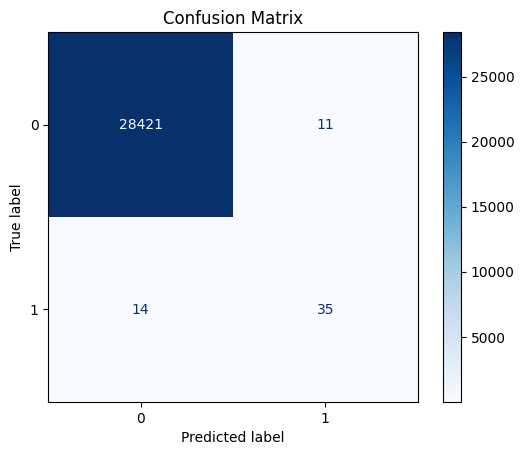

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print individual scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report for a detailed overview
print(classification_report(y_test, y_pred))

Accuracy: 0.9991
Precision: 0.7609
Recall: 0.7143
F1-Score: 0.7368
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.76      0.71      0.74        49

    accuracy                           1.00     28481
   macro avg       0.88      0.86      0.87     28481
weighted avg       1.00      1.00      1.00     28481

